# Submission Exercises after Lecture 3

This notebook contains the submission exercises with instructions and explanations. You have to submit this notebook as a part of Submission 1.

Work through the cells below in a sequential order, executing each cell as you progress. Throughout the notebook, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

Along the way, you will also find questions. Try to reflect on the questions before/after running the code.

You have four exercises to complete. In total, you can get 15 points out of 60 points for Submission 1 for completing all marked exercises related to lecture 3.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution). Some pieces of code were adopted from the notebooks developed at the  [Idiap Research Institute](https://www.idiap.ch) by [Olivier Canévet](mailto:olivier.canevet@idiap.ch).

Any reproduction or distribution of this document, in whole or in part, is prohibited unless permission is granted by the authors.

<!--
SPDX-FileCopyrightText: Copyright (c) 2019-2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
SPDX-FileContributor: Olivier Canévet <olivier.canevet@idiap.ch>
-->

In [1]:
import getpass
import os
import random
import re
import tarfile
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.utils as utils
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
from collections import Counter
import torchvision.models as models
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
from IPython.display import clear_output

##### **Following pieces of code are taken from the Practice 3 notebook with slight modifications in the model's architecture and hyperparameters. Here the solutions for the exercises are provided.**
We are going to load a dataset composed of images of the following fruits: apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

The dataset has the following structure:

```text
fruit_dataset/
|-- train/
|   |-- apple/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 000.jpg
|   |   |-- 001.jpg
|   |   |-- ...
|
|-- val/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
|   |-- banana/
|   |   |-- 040.jpg
|   |   |-- 041.jpg
|   |   |-- ...
```

which can be loaded as is with the ImageFolder class of PyTorch.
Check out the documentation for more details: https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html

In [2]:
# This piece of code is adopted from the notebooks developed at the Idiap Research Institute by Olivier Canévet.
# For efficient usage of the hardware resources when running on JupyterHub (EPFL),
# we will limit the number of threads.

if re.search(r'^https://.*noto.*\.epfl\.ch$', os.environ.get("EXTERNAL_URL", "")) != None:
    num_threads_limit = 2
else:
    num_threads_limit = torch.get_num_threads()
print(f"Limiting the number of threads to {num_threads_limit}")
torch.set_num_threads(num_threads_limit)
print(f"PyTorch is using {torch.get_num_threads()} threads")

_ = torch.set_flush_denormal(True)

Limiting the number of threads to 2
PyTorch is using 2 threads


In [4]:
'''
Note: you do NOT need the code that is commented in this cell if you use Gnoto
platform. However, in case you need to access the dataset outside of Gnoto
platform, you can use the following code. Do NOT run this code on Gnoto.
'''
# this is the path to the dataset on Gnoto platform
DATADIR = "/EE559-shared/"

# DATADIR = "."
# url = "https://www.idiap.ch/~ocanevet/master-ai/fruits.tgz"
# DATA_TAR_FILE = Path(DATADIR) / "fruits.tgz"
# if not Path(DATA_TAR_FILE).is_file():
#     print(f"Downloading data set to {DATA_TAR_FILE}")
#     datasets.utils.download_and_extract_archive(url, download_root=DATADIR)
#     os.rename("fruits", "fruit_dataset")
# else:
#     print(f"Data set already in {DATA_TAR_FILE}")

If you have not changed anything on the default paths and use Gnoto platform, the following code will load the dataset:
- the training images are in the folder ```<DATADIR>/ fruit_dataset / train```
- the validation images are in the folder ```<DATADIR>/ fruit_dataset / valid```

In [5]:
#path to the train and val folders
train_dir = Path(DATADIR) / "fruit_dataset" / "train"
valid_dir = Path(DATADIR) / "fruit_dataset" / "val"

#name of the classes
classes = ("apple", "banana", "bean", "carrot", "grape", "onion", "pear",
           "potato", "strawberry", "tomato")

classes = ("apple", "banana", "bean", "carrot", "grape", "onion", "pear", "potato", "strawberry", "tomato")
NUM_CLASSES = len(classes) #apple, banana, bean, carrot, grape, onion, pear, potato, strawberry, tomato.

# batch size
batch_size = 10


In PyTorch, when you load a dataset, you can pass a set of transformations to perform on the images before feeding them to a network. Usually, the transformations consist of: resizing and cropping the image, casting to a tensor, normalizing the image, etc.

Here you can find the available transformations in PyTorch: https://pytorch.org/vision/stable/transforms.html

In [6]:
# Adaptation of the code from Practice 2
# mean and std for normalisation are chosen based on ImageNet statistics

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

train_set = datasets.ImageFolder(train_dir, transform)
valid_set = datasets.ImageFolder(valid_dir, transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False)


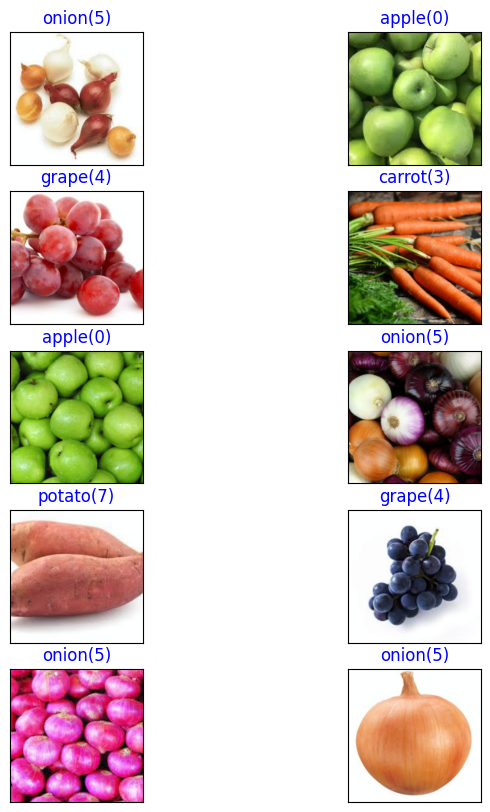

In [7]:
# Visualization of images
'''
Get some random training images
A quick explanation of iter() and next():
https://stackoverflow.com/questions/62549990/what-does-next-and-iter-do-in-pytorchs-dataloader
'''

def plot_images_from_dataset(images, labels):
    batch_size = images.shape[0]
    fig = plt.figure(figsize=(8, 10))
    for idx in np.arange(int(batch_size)):
        ax = fig.add_subplot(5, int(batch_size/5), idx+1, xticks=[], yticks=[])
        img = np.squeeze(images[idx])
        img = img.to(torch.float64)
        # revert normalisation
        img = img * np.expand_dims(np.array([0.229, 0.224, 0.225]), (1, 2)) + np.expand_dims(np.array([0.485, 0.456, 0.406]), (1, 2))
        img = np.clip(img, 0, 1)
        plt.imshow(np.transpose(img, (1,2,0)))
        ax.set_title("{}({})".format(classes[labels[idx]],str(labels[idx].item())),
                    color=("blue"))

dataiter = iter(train_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

How many images in the train set:  400
Images per class in dataloader:  {'banana': 40, 'carrot': 40, 'onion': 40, 'strawberry': 40, 'pear': 40, 'bean': 40, 'apple': 40, 'tomato': 40, 'potato': 40, 'grape': 40}


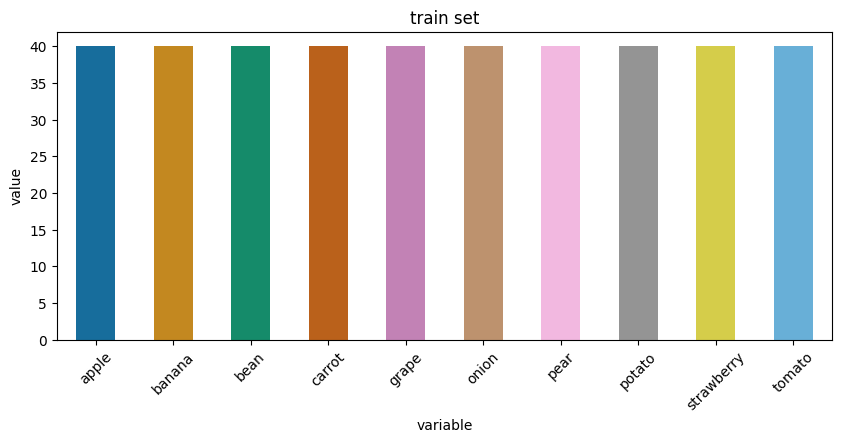

In [8]:
# class distribution

print("How many images in the train set: ", len(train_set.targets))

# later in this exercise you will explore the ways to rebalance the data in the dataloader
def plot_class_distribution_for_dataloader(dataloader, set_name):
# count how many images are outputted by dataloader per class
    count_dict = {}
    for _, target in dataloader:
        for t in target:
            t = classes[int(t)]
            if t not in count_dict:
                count_dict[t] = 0
            count_dict[t] += 1
    print("Images per class in dataloader: ", count_dict)
    plt.figure(figsize=(10, 4))
    #plot the class distribution
    sns.barplot(data=pd.DataFrame.from_dict([count_dict])[list(classes)].melt(),
                  x="variable", y="value", hue="variable", palette="colorblind", width = 0.5,  dodge=False)

    plt.title(f"{set_name} set")
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution_for_dataloader(train_loader, set_name='train')
## the training set is perfectly balanced: same number of images for all classes

## Metrics
Introducing simple metrics, such as accuracy and F1-score.

In [9]:
def f1(preds, target):
    return f1_score(target, preds, average='macro')

def acc(preds, target):
    return accuracy_score(target, preds)

## Model

In [10]:
class FruitNet(nn.Module):
    def __init__(self, weights=None):
        super().__init__()
        # Loading AlexNet
        self.model = models.alexnet(weights=weights)
        # to reduce the computational complexity we reduce the size and number of hidden layers
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.35, inplace=False),
            nn.Linear(in_features=9216, out_features=128, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=128, out_features=10, bias=True)
        )

    def freeze_feature_layers(self):
        # freeze the feature extraction part
        for param in self.model.features:
            param.requires_grad_(False)

    def forward(self, x):
        return self.model(x)

## Training and evaluation, logging and plotting the metrics

In [11]:
def train_epoch(model, optimizer, criterion, metrics, train_loader, device):
    '''
    device = torch.device('cuda') or torch.device('cpu') if no GPU available
    '''
    # we activate the training state for the model
    model.train()

    # initialize epoch loss and metrics
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    # we iterate over the batches
    for batch_num, (x_batch, y_batch) in tqdm(enumerate(train_loader)):
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            _, preds = torch.max(outputs, 1)

        with torch.no_grad():
            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(train_loader)

    clear_output()
    print('train Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [12]:
def evaluate(model, criterion, metrics, test_loader, device):

    model.eval()
    epoch_loss = 0
    epoch_metrics = dict(zip(metrics.keys(), torch.zeros(len(metrics))))

    for batch_num, (x_batch, y_batch) in enumerate(test_loader):
        with torch.no_grad(): # since we do not update the model, we do not compute gradients
            data = x_batch.to(device)
            target = y_batch.to(device)

            outputs = model(data)
            loss = criterion(outputs, target)
            _, preds = torch.max(outputs, 1)

            for k in epoch_metrics.keys():
                epoch_metrics[k] += metrics[k](preds.cpu(), target.cpu())

            epoch_loss += loss.item()

    epoch_loss /= len(test_loader)

    for k in epoch_metrics.keys():
          epoch_metrics[k] /= len(test_loader)

    print('eval Loss: {:.4f}, '.format(epoch_loss),
          ', '.join(['{}: {:.4f}'.format(k, epoch_metrics[k]) for k in epoch_metrics.keys()]))

    return epoch_loss,  epoch_metrics

In [13]:
def plot_training(train_loss, test_loss, metrics_names, train_metrics_logs, test_metrics_logs):
    fig, ax = plt.subplots(1, len(metrics_names) + 1, figsize=((len(metrics_names) + 1) * 5, 5))

    ax[0].plot(train_loss, c='blue', label='train')
    ax[0].plot(test_loss, c='orange', label='test')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend()

    for i in range(len(metrics_names)):
        ax[i + 1].plot(train_metrics_logs[i], c='blue', label='train')
        ax[i + 1].plot(test_metrics_logs[i], c='orange', label='test')
        ax[i + 1].set_title(metrics_names[i])
        ax[i + 1].set_xlabel('epoch')
        ax[i + 1].legend()

    plt.show()

def update_metrics_log(metrics_names, metrics_log, new_metrics_dict):
    '''
    - metrics_names: the keys/names of the logged metrics
    - metrics_log: existing metrics log that will be updated
    - new_metrics_dict: epoch_metrics output from train_epoch and evaluate functions
    '''
    for i in range(len(metrics_names)):
        curr_metric_name = metrics_names[i]
        metrics_log[i].append(new_metrics_dict[curr_metric_name])
    return metrics_log

In [14]:
def train_cycle(model, optimizer, criterion, metrics, train_loader, test_loader, n_epochs, device):
    train_loss_log,  test_loss_log = [], []
    metrics_names = list(metrics.keys())
    train_metrics_log = [[] for i in range(len(metrics))]
    test_metrics_log = [[] for i in range(len(metrics))]


    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_metrics = train_epoch(model, optimizer, criterion, metrics, train_loader, device)

        test_loss, test_metrics = evaluate(model, criterion, metrics, test_loader, device)

        train_loss_log.append(train_loss)
        train_metrics_log = update_metrics_log(metrics_names, train_metrics_log, train_metrics)

        test_loss_log.append(test_loss)
        test_metrics_log = update_metrics_log(metrics_names, test_metrics_log, test_metrics)

        plot_training(train_loss_log, test_loss_log, metrics_names, train_metrics_log, test_metrics_log)
    return train_metrics_log, test_metrics_log


First, you have to train a neural network on the Fruits dataset without any augmentation.

train Loss: 0.1933,  ACC: 0.9600, F1-weighted: 0.9384
eval Loss: 0.3986,  ACC: 0.8700, F1-weighted: 0.6780


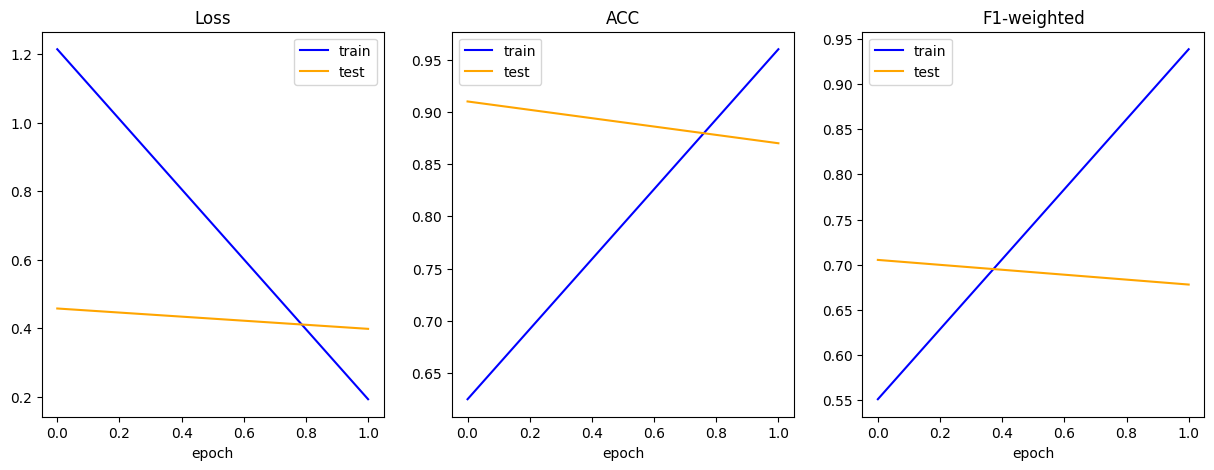

In [15]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion.to(device)

train_metrics_log_base, test_metrics_log_base = train_cycle(model, optimizer, criterion, metrics, train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')

 You should get test accuracy >= 86%. The model can start to overfit.

## Augmentation

##### 1.3.1 [1 point] Data augmentation on the balanced dataset. Application of various augmentation techniques to the dataset to improve performance and decrease overfitting. The task includes finding a suitable combination of data transformations.

**TODO** Enhance the training dataset by incorporating up to three torchvision transformations. Retrain the network to improve accuracy by at least 1 percentage point compared to the previous results. The use of data augmentation should help reduce overfitting in the updated model.

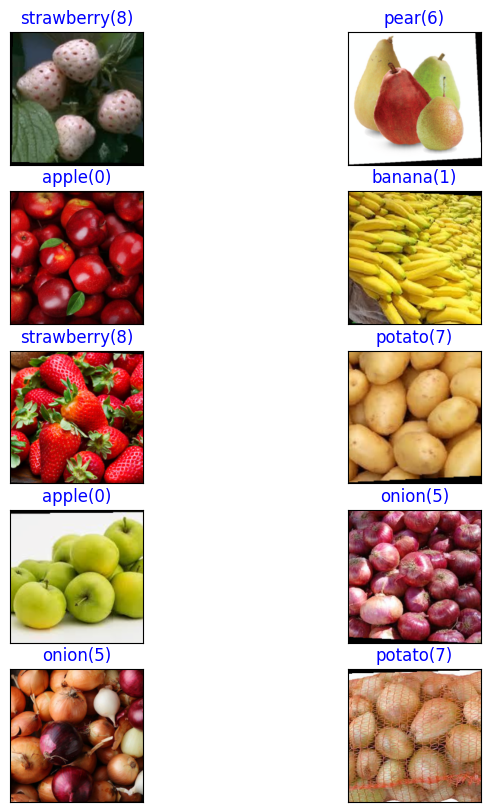

In [31]:
'''
TODO: add up to three transformations from torchvision transforms to improve
the performance. The transformations should be different from ones that are
already listed below like Resize or CenterCrop.
'''
augmented_transform_train = transforms.Compose([
    # YOUR CODE HERE
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=3, translate=(0.03, 0.03)), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

augmented_train_set = datasets.ImageFolder(train_dir, augmented_transform_train)
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_set, batch_size=batch_size, shuffle=True)

# plot augmented images
dataiter = iter(augmented_train_loader)
images, labels = next(dataiter)

plot_images_from_dataset(images, labels)


# Validation set stays as it is

train Loss: 0.2954,  ACC: 0.9300, F1-weighted: 0.8935
eval Loss: 0.3850,  ACC: 0.8900, F1-weighted: 0.6506


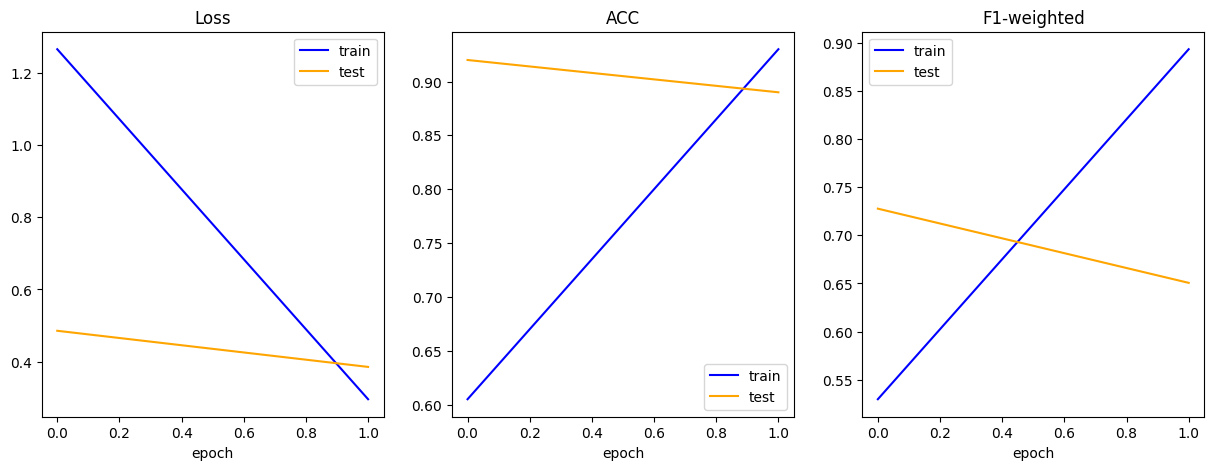

In [32]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion.to(device)

train_metrics_log_aug_imp, test_metrics_log_aug_imp = train_cycle(model, optimizer, criterion, metrics, augmented_train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

Ideally, you should achive improvement in the performance in both accuracy and F1. However, training process contains randomness and instability which can lead to slight decrease in F1 score (which will be accepted as long as accuracy is increased by at least 1p.p.). The reasons why this inconsistency happends are out of the scope of the current exercise.

In [34]:
assert test_metrics_log_aug_imp[0][-1] - test_metrics_log_base[0][-1] >= 0.01 # testing accuracy

##### 1.3.2 [2 points] Data augmentation on the balanced dataset. Application of various augmentation techniques to the dataset to degrade the performance. The task includes finding a suitable combination of various data transformations, and stating the reason for performance degradation.

**TODO** Augment the training dataset by incorporating up to three torchvision transformations. Retrain the network to achieve at least a 10 p.p. drop in accuracy, and at least 10 p.p. drop in F1 score compared to the base model. Explain the cause for the performance drop in **one** sentence.

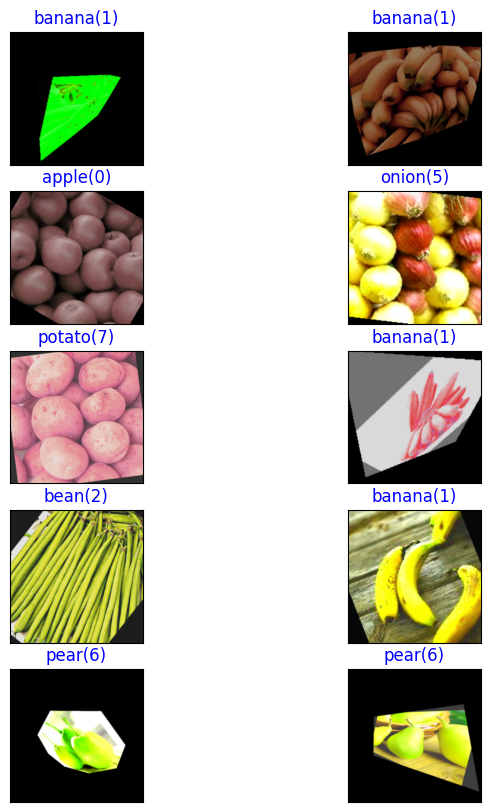

In [35]:
'''
TODO: add up to three transformations from torchvision transforms to degrade
the performance. The transformations should be different from ones that are
already listed below like Resize or CenterCrop.
'''

neg_augmented_transform_train = transforms.Compose([
    # YOUR CODE HERE
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.7, contrast=0.7, saturation=0.7, hue=0.2),
    transforms.RandomPerspective(distortion_scale=0.8, p=0.5),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])


neg_augmented_train_set = datasets.ImageFolder(train_dir, neg_augmented_transform_train)
neg_augmented_train_loader = torch.utils.data.DataLoader(neg_augmented_train_set, batch_size=batch_size, shuffle=True)


# plot augmented images
dataiter = iter(neg_augmented_train_loader)
images, labels = next(dataiter)

plot_images_from_dataset(images, labels)


# test set stays as it is

train Loss: 1.4876,  ACC: 0.5100, F1-weighted: 0.4123
eval Loss: 1.0065,  ACC: 0.7200, F1-weighted: 0.4889


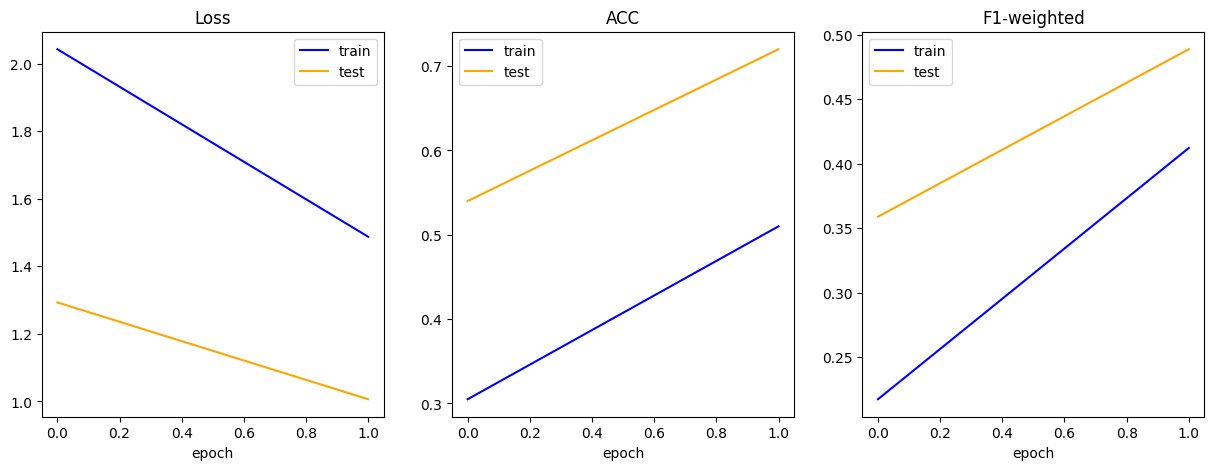

In [36]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion.to(device)

train_metrics_log_aug_deg, test_metrics_log_aug_deg = train_cycle(model, optimizer, criterion, metrics, neg_augmented_train_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_set.pth')

In [37]:
assert test_metrics_log_aug_deg[0][-1] - test_metrics_log_base[0][-1] <= - 0.10  # testing accuracy
assert test_metrics_log_aug_deg[1][-1] - test_metrics_log_base[1][-1] <= - 0.10  # testing F1

**TODO**: explain the cause of the performance degradation in one sentence.

**WRITE YOUR ANSWER HERE**

The aggressive augmentations severely distort the natural features of the images, making it difficult for the network to extract meaningful and consistent patterns during training.

## Weighted sampler

##### 1.3.3  [7 points] Construct and use a weighted sampler on the imbalanced dataset. 

Now imagine that your training data was collected in a year, when the harvest of tomato, potato and strawberry was very bad. As a result, you were able to take fewer photos of those fruits and vegetables and now have less training data for these classes. While you still want the network to work equally well for all the classes, and to test that you have to keep the validation dataset balanced.

We imitate the lower number of photos of potatoes, strawberries, and tomatoes in the train dataset by dropping 20%, 50%, and 70% of images of these classes, chosen randomly for the mentioned fruits (and veg) correspondingly.


First, train the model on the imbalanced dataset. Reflect on the changes in accuracy and F1 score in comparison to the model trained on the full dataset.


In [38]:
# we selected for you which files will be excluded from the training set

classes_dropped_images_path = {}
classes_dropped_images_path['potato'] = ['038.jpg', '008.jpg', '034.jpg', '018.jpg', '029.jpg', '002.jpg', '006.jpg', '036.jpg']
classes_dropped_images_path['strawberry'] = ['039.jpg', '035.jpg', '019.jpg', '008.jpg', '002.jpg', '031.jpg',
       '006.jpg', '007.jpg', '024.jpg', '012.jpg', '020.jpg', '000.jpg',
       '023.jpg', '009.jpg', '018.jpg', '014.jpg', '016.jpg', '029.jpg',
       '030.jpg', '010.jpg']
classes_dropped_images_path['tomato'] = ['007.jpg', '009.jpg', '034.jpg', '027.jpg', '014.jpg', '026.jpg',
       '010.jpg', '024.jpg', '003.jpg', '035.jpg', '033.jpg', '036.jpg',
       '002.jpg', '016.jpg', '023.jpg', '000.jpg', '039.jpg', '015.jpg',
       '038.jpg', '028.jpg', '022.jpg', '001.jpg', '011.jpg', '031.jpg',
       '020.jpg', '029.jpg', '017.jpg', '006.jpg']

for k in classes_dropped_images_path.keys():
    # get a path for dropped training samples
    classes_dropped_images_path[k] = [str(train_dir / k / x) for x in classes_dropped_images_path[k]]

def not_dropped_images(filepath):
    '''
    Function to drop the images from the dataset.
    '''
    for k in classes_dropped_images_path:
        if filepath in classes_dropped_images_path[k]:
            return False
    return True

'''
We use augmentation implemented in the previous task for more stable results.
If you didn't do the previous task, replace `augmented_transform_train` with
`transform` in the next line
'''

train_imbalanced_set = datasets.ImageFolder(train_dir, augmented_transform_train, is_valid_file=not_dropped_images)

train_imbalanced_loader = torch.utils.data.DataLoader(train_imbalanced_set, batch_size=batch_size, shuffle=True)

Images per class in dataloader:  {'bean': 40, 'pear': 40, 'potato': 32, 'carrot': 40, 'banana': 40, 'apple': 40, 'grape': 40, 'onion': 40, 'tomato': 12, 'strawberry': 20}


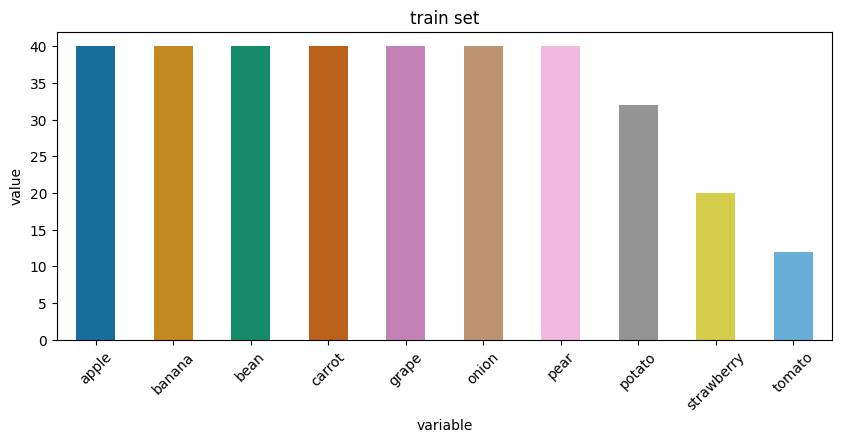

In [39]:
#let's look at the distribution of classes in train loader
plot_class_distribution_for_dataloader(train_imbalanced_loader, set_name='train')

Images per class in dataloader:  {'apple': 10, 'banana': 10, 'bean': 10, 'carrot': 10, 'grape': 10, 'onion': 10, 'pear': 10, 'potato': 10, 'strawberry': 10, 'tomato': 10}


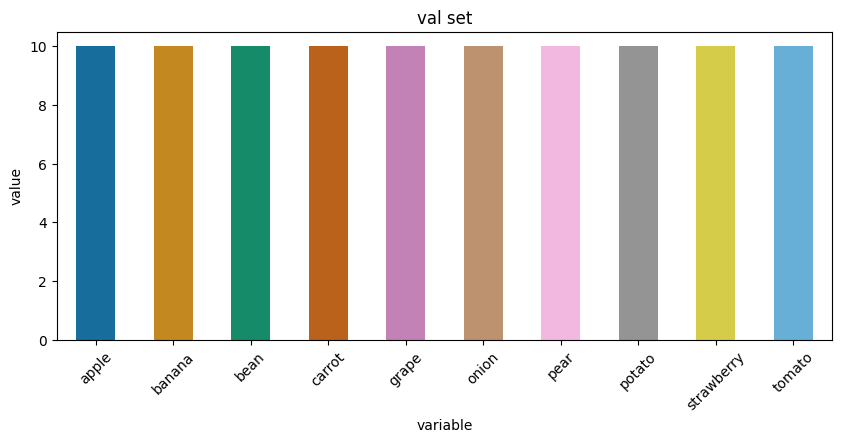

In [40]:
#and distribution of classes in valid loader
plot_class_distribution_for_dataloader(valid_loader, set_name='val')
# test set stays as it is

train Loss: 0.2947,  ACC: 0.9300, F1-weighted: 0.8842
eval Loss: 0.3936,  ACC: 0.8600, F1-weighted: 0.6387


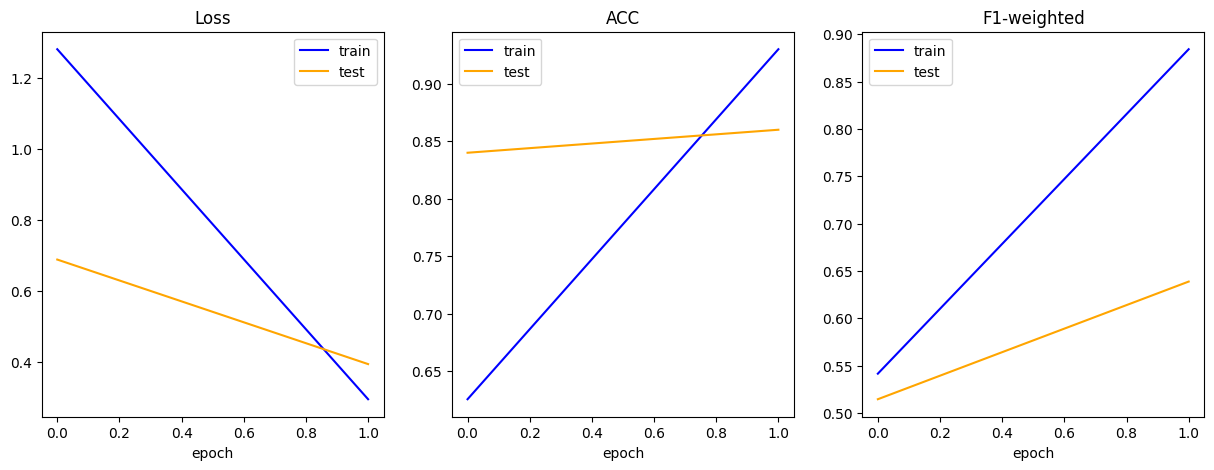

In [42]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001

'''
For the exercises on the smaller imbalanced dataset, we include weight_decay
to reduce overfitting
'''
weight_decay = 0.05

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_imbalanced_dataset.pth')

We expect achieved F1 score to be lower than 0.65.

**TODO**: write a custom batch data sampler, that resamples the dataset with respect to desired weights of the classes. The under-represent classes should have higher weight.

You are **not allowed** to use torch implementation of random sampler and have to create the class on your own. You are only allowed to inherit from a standart sampler torch.utils.data.Sampler.



In [48]:
from torch.utils.data import Sampler
class CustomDataSampler(Sampler):
    def __init__(self,
                 dataset,
                 sampling_weights,
                 ):
        '''
        sampling_weights: dictionary, where keys are image classes and values
        are weights of each class, not necessarily summing up to one.

        dataset: imbalanced dataset
        '''

        super().__init__(dataset)
        self.dataset = dataset
        self.number_of_classes = len(sampling_weights)
        self.sampling_weights = sampling_weights
        # TODO: initialise other attributes if you need
        # YOUR CODE HERE
        self.class_to_indices = {}
        for idx, label in enumerate(self.dataset.targets):
            if label not in self.class_to_indices:
                self.class_to_indices[label] = []
            self.class_to_indices[label].append(idx)

    def __iter__(self):
        '''
        TODO: You need to create a list of indices that will be used in the dataloader.
        The output should be iter(list_of_indexes).

        The length of list_of_indexes should be equal to
        sum([class_weight * number_of_elements_in_this_class for each_of_the classes]).

        You can add some randomness in how many examples are drawn from each class.

        ====TOY EXAMPLE====

        Consider your dataset for binary classification contains samples
        [[a, 0], [b, 0], [c, 0], [d, 0], [e, 1], [f, 1]],
        where 1st element in the pair is input(letters) and the 2nd is target (0 or 1).

        dataset[0] will return the first element of the dataset: [a, 0] and sampling_weights are {0: 1, 1: 2}

        The expected output of the sampler will be a list of indexes that
        should be drawn from the dataset. The length of the outputted indexes
        list should be equal to 8. Although the implementations of the sampler
        and the amount of randomness inside can vary. You can decide yourself
        how random your sampler will be.

        One possible list of outputted indexes with one implementation can be
        [0, 1, 2, 3, 4, 5, 4, 4]. In the dataloader, corresponding elements of
        the outputted indexes will be drawn from the dataset one by one.

        Another possible output can be [0, 0, 2, 4, 5, 4, 4, 5], where we see
        that not all elements from the original dataset are going to be present
        in this epoch and the weights of the classes in the outputted indexes
        are slightly different from sampling_weights. This output includes more
        randomness, which is fine for bigger datasets.
        '''
        # YOUR CODE HERE
        indices_list = []
        for class_label, indices in self.class_to_indices.items():
            weight = self.sampling_weights[class_label]
            n_examples = len(indices)
            n_to_draw = int(round(n_examples * weight))
            sampled_indices = random.choices(indices, k=n_to_draw)
            indices_list.extend(sampled_indices)
        random.shuffle(indices_list)
        return iter(indices_list)


    def __len__(self):
        # TODO: return len of the resampled dataset
        # YOUR CODE HERE
        total = 0
        for class_label, indices in self.class_to_indices.items():
            weight = self.sampling_weights[class_label]
            total += int(round(len(indices) * weight))
        return total

/opt/jlab-env/lib/python3.12/site-packages/torch/utils/data/sampler.py:76: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Images per class in dataloader:  {'bean': 40, 'potato': 40, 'tomato': 40, 'apple': 40, 'pear': 40, 'grape': 40, 'onion': 40, 'carrot': 40, 'banana': 40, 'strawberry': 40}


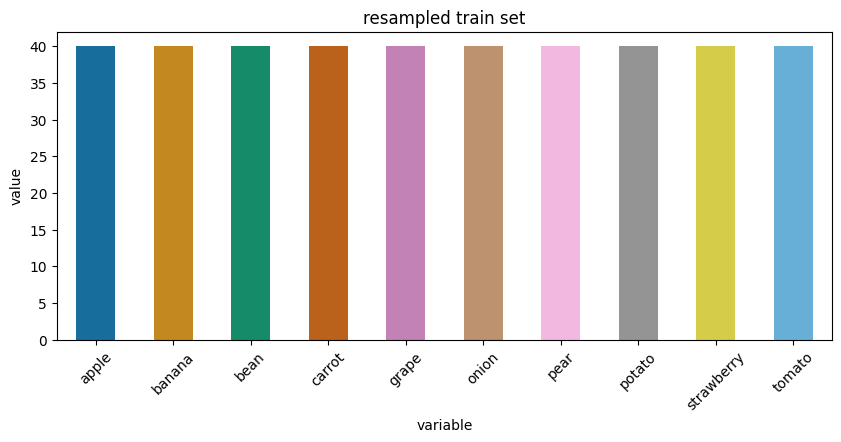

In [44]:
# initialise desired sampling weights
sampling_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1 / 0.8, 8: 1 / 0.5, 9: 1 / 0.3}

#initialize datasampler
train_sampler = CustomDataSampler(train_imbalanced_set, sampling_weights=sampling_weights)
train_imbalanced_resampled_loader = torch.utils.data.DataLoader(train_imbalanced_set, sampler=train_sampler, batch_size=batch_size)

#let's look at distribution of classes in train loader
plot_class_distribution_for_dataloader(train_imbalanced_resampled_loader, set_name='resampled train')
# each class should have around 40 images

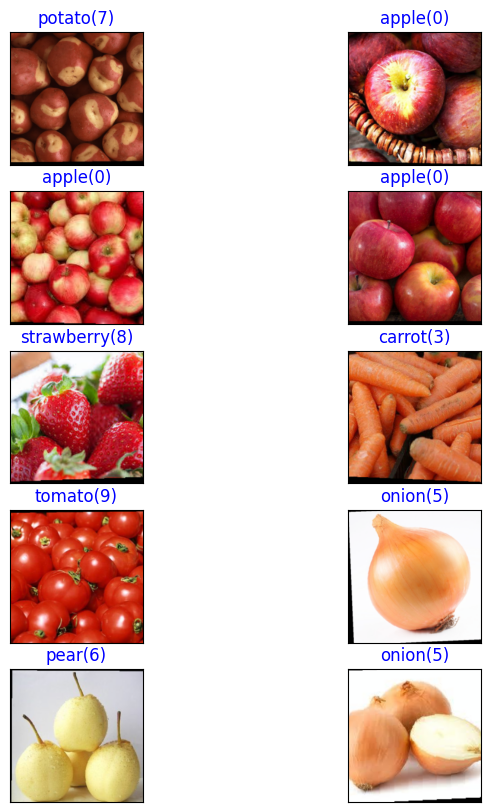

In [45]:
dataiter = iter(train_imbalanced_resampled_loader) #iter() returns an iterator
images, labels = next(dataiter) # call next() on the iterator to get the first iteration

plot_images_from_dataset(images, labels)

If you did everything correctly the train_imbalanced_resampled_loader should contain relatively similar number of images per each class around 40.


train Loss: 0.2855,  ACC: 0.9225, F1-weighted: 0.8749
eval Loss: 0.3701,  ACC: 0.8900, F1-weighted: 0.6637


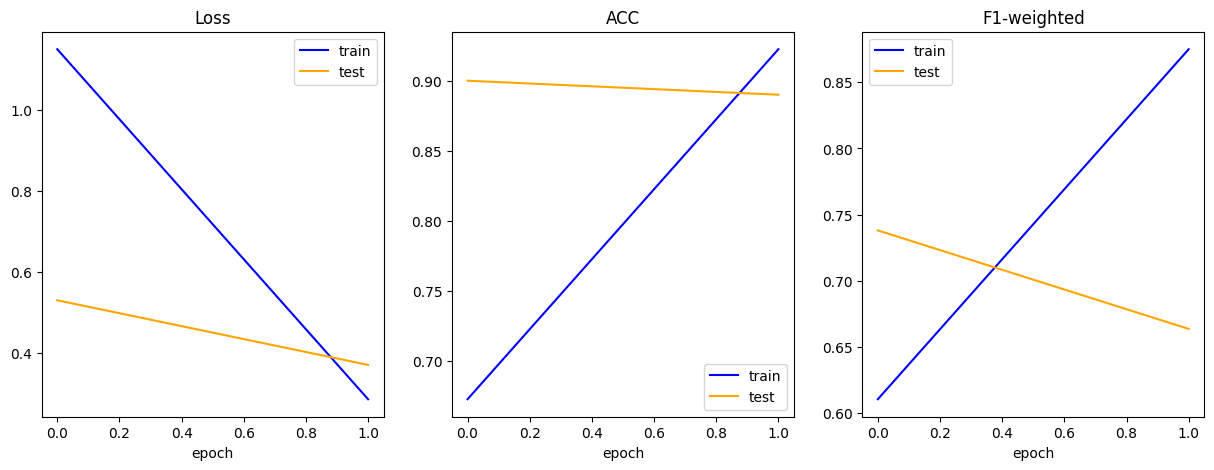

In [46]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001
weight_decay = 0.05

criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_resampled_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_imbalanced_resampled_dataset.pth')

Analyse how accuracy and F1 score differently react to the changes in the predictions (no written answer needed for analysis).

## Weignted Cross-Entropy loss

##### 1.3.4  [5 points] Construct a weighted cross-entropy loss function to mitigate the imbalance of the dataset. Train the model with this function and analyse the results. The loss should reflect the frequency of appearance of each class, giving less weight to common classes to improve balance.

You have to implement a weighted cross-entropy loss function, where each class corresponds to a certain weight, and the sequence of weights does not necessarily sum up to one. You are **not allowed** to use torch.nn.CrossEntropyLoss() and have to implement the whole loss by yourself using simple mathematical operations in torch.

You should implement Cross Entropy Loss using torch.

--------------------
$N$ - batch size

$C$ - number of classes


$input$ - 2D torch array of size (N, C) containing logits (values in [-$\infty$, $\infty$]), where $input_{i, j}$ corresponds to a logit of a sample $i$ for the class $j$.

$target$ - 1D torch array of integers of size (N). The values of target represent the indexes of the true class labels and are integers in the range [0, C - 1], where $target_i$ corresponds to an index of a correct class for the $i$-th sample.

$w$ - 1D torch array of size (C), containing rescaling weights, given to each class, where $w_c$ corresponds to a weight of the class $c$

$N$ - number of samples in the input

Implement the Cross Entropy loss function $L(input, target)$ according to the formula.

$$
l_i = w_{target_i} * \log\frac{\exp(input_{i, target_i})}{\sum_{c=0}^{C-1}\exp(input_{i,c})},
$$

where $l_i$ is a loss computed for one sample.

$$
L(input, target) = -\sum_{i=0}^{N - 1} \frac{1}{\sum_{j=0}^{N - 1}w_{target_j}}l_i
$$

The output of the function should be a single float value.


In [52]:
class CustomCRELossForImbalancedDataset():
    def __init__(self, weights):

        self.weights = weights

        # TODO: initialise other attributes if you need
        # YOUR CODE HERE
        self.weights = weights


    def __call__(self, input, target):
        '''
        TODO: write custom weighted cross-entropy loss
        loss = ...
        '''
        # YOUR CODE HERE
        N = input.shape[0]
        sum_exp = torch.sum(torch.exp(input), dim=1)  # shape: (N,)
        correct_logits = input[torch.arange(N), target]  # shape: (N,)
        log_probs = correct_logits - torch.log(sum_exp)
        sample_weights = self.weights[target]  # shape: (N,)
        li = sample_weights * log_probs  # shape: (N,)
        norm = torch.sum(sample_weights)
        loss = -torch.sum(li) / norm
        return loss

In [53]:
# test your solution
x = torch.Tensor(np.array([[1, 2, 1, 3, 5, 7, 8, 4, 2, 1],
                              [1, 2, 1, 3, 2, 1, 5, 6, 5, 1]]))
y = torch.LongTensor(np.array([1, 8])).to(torch.long)

sampling_weights = torch.Tensor([1, 1, 1, 1, 1, 1, 1, 1 / 0.8, 1 / 0.5, 1 / 0.3])
loss = CustomCRELossForImbalancedDataset(sampling_weights)
answ = loss(x, y).detach().numpy()

assert (answ >= 3.200426 - 1e-5) and (answ <= 3.200426 + 1e-5)


train Loss: 0.3007,  ACC: 0.9357, F1-weighted: 0.8934
eval Loss: 0.4060,  ACC: 0.8800, F1-weighted: 0.6802


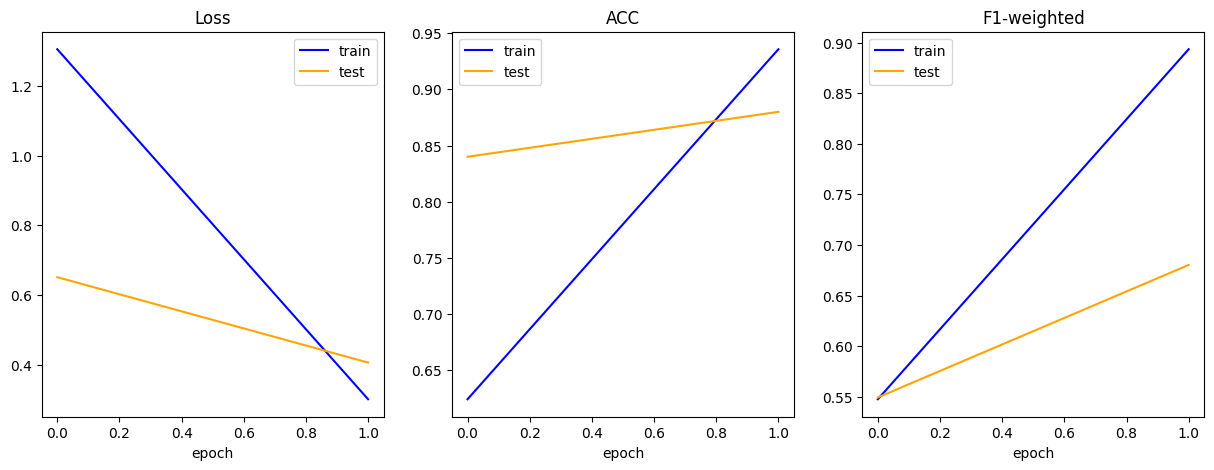

In [54]:
torch.manual_seed(42)

model = FruitNet(weights="IMAGENET1K_V1")
model.freeze_feature_layers()

learning_rate = 0.0001
weight_decay = 0.05

sampling_weights = torch.Tensor([1, 1, 1, 1, 1, 1, 1, 1 / 0.8, 1 / 0.5, 1 / 0.3]).to(device)
criterion = CustomCRELossForImbalancedDataset(sampling_weights)
metrics = {'ACC': acc, 'F1-weighted': f1}
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# train two more apochs in comparison to previous training
N_EPOCHS = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
# criterion.to(device)

train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_imbalanced_loader, valid_loader, n_epochs=N_EPOCHS, device=device)

# save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model_trained_on_augmented_imabalnced_set_with_weighted_loss.pth')

Ideally your F1 score should be higher when adapting weighted sampling or weighted loss than when model is trained on imbalanced dataset without weighted loss or weighted sampling. Although, the dataset for this assignment is very small and training on small number of epochs can be unstable, which can lessen the effect of augmentations, weighted sampling and weighted loss